In [1]:
import pandas as pd
import numpy as np
import numpy.linalg as nla
import numpy.random as nrd
import matplotlib.pyplot as plt
from itertools import combinations
from collections import defaultdict

# Exercise 7.9

For the prostate data of Chapter 3, carry out a best-subset linear
regression analysis, as in Table 3.3 (third column from left). Compute the
AIC, BIC, five- and tenfold cross-validation, and bootstrap .632 estimates
of prediction error. Discuss the results.

# Solution

Let's introduce some useful functions for the notebook,

In [2]:
def standardise(X,X_test):
    mu = np.mean(X,axis=0)
    sig = np.std(X,axis=0)
    
    return (X-mu)/sig, (X_test-mu)/sig

def lin_reg(X,y):
    return nla.pinv(X.T @ X) @ X.T @ y

def mean_squares_err(X,y,beta):
    return np.mean((y - X @ beta)**2)

def best_subset_selection(X,y,k):
    
    N,p = X.shape
    min_err = np.inf
    err_list = []
    
    for exclude in combinations(range(1,p),k):
        X_bs = np.delete(X,exclude,axis=1)
        beta = lin_reg(X_bs,y)
        err = mean_squares_err(X_bs,y,beta)
        if err < min_err:
            min_err = err
            opt_exclusion = exclude
            opt_beta = beta
        err_list.append(err)
            
    return (opt_beta,opt_exclusion,min_err,err_list)

def cross_validation_split(X,y,n):
    N,_ = X.shape
    delta = N//n
    
    train_set = []
    cv_set = []
    
    for i in range(0,n):
        X_train = np.vstack((X[:i*delta],X[(i+1)*delta:]))
        y_train = np.hstack((y[:i*delta],y[(i+1)*delta:]))
        train_set.append((X_train,y_train))
        
        X_cv = X[i*delta:(i+1)*delta]
        y_cv = y[i*delta:(i+1)*delta]
        cv_set.append((X_cv,y_cv))
        
    return (train_set,cv_set)

def select_bootstrap_set(X,y):
    
    N,_ = X.shape
    indices_in = nrd.choice(N, size=N, replace=True)
    indices_out= [i for i in range(N) if not i in set(indices_in)]
    
    X_bs = X[indices_in]
    y_bs = y[indices_in]
    
    return X_bs, y_bs, indices_out

In [3]:
data_url = 'https://web.stanford.edu/~hastie/ElemStatLearn/datasets/prostate.data'
df_prostate = pd.read_csv(data_url,sep='\t',index_col=0)
df_prostate.tail()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
93,2.830268,3.876396,68,-1.386294,1,1.321756,7,60,4.385147,T
94,3.821004,3.896909,44,-1.386294,1,2.169054,7,40,4.684443,T
95,2.907447,3.396185,52,-1.386294,1,2.463853,7,10,5.143124,F
96,2.882564,3.773910,68,1.558145,1,1.558145,7,80,5.477509,T
97,3.471966,3.974998,68,0.438255,1,2.904165,7,20,5.582932,F


Here we shuffle and standardize the data

In [4]:
df_prostate = df_prostate.sample(frac=1)

# Divide set into training and test
train_set = df_prostate[df_prostate['train']=='T']
train_set.pop('train')
test_set = df_prostate[df_prostate['train']=='F']
test_set.pop('train')

# Training and test response
y_train = train_set.pop('lpsa').to_numpy()
y_test = test_set.pop('lpsa').to_numpy()

# Standardized inputs
X_train, X_test = standardise(train_set.to_numpy(),test_set.to_numpy())

N,p = X_train.shape
M,_ = X_test.shape

X_train = np.hstack((np.ones((N,1)),X_train))
X_test = np.hstack((np.ones((M,1)),X_test))

### Best-Subset Selection

In [5]:
train_error_bs = {}
min_err_list = []
err_test = []

for k in range(1,p+1):
    beta,excl,min_err,err_list = best_subset_selection(X_train,y_train,k)
    train_error_bs[k] = err_list
    min_err_list.append(min_err)
    X_test_bs = np.delete(X_test,excl,axis=1)
    err_test.append(mean_squares_err(X_test_bs,y_test,beta))
    
min_err_list.reverse()
err_test.reverse()

The error curves for best subset selection (training and test)

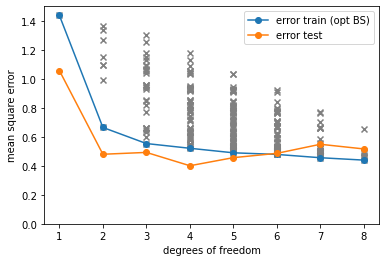

In [6]:
for k in range(0,p):
    y_coord = train_error_bs[k+1]
    x_coord = np.full(len(y_coord),p-k) 
    plt.scatter(x_coord,y_coord,marker='x',c='grey')

dofs = list(range(1,p+1))
plt.plot(dofs,min_err_list,'o-',label='error train (opt BS)')
plt.plot(dofs,err_test,'o-',label='error test')
plt.xlabel('degrees of freedom')
plt.ylabel('mean square error')
plt.ylim((0,1.5))
plt.legend()
plt.show()

### AIC and BIC

In [7]:
# The sigma can be approx as the error of a low-bias (high variance) model (high dofs)
sig_low_bias = min_err_list[-1]

AIC = []
BIC = []

for dof in dofs:
    AIC.append(min_err_list[dof-1] + 2*sig_low_bias*dof/N)
    BIC.append(min_err_list[dof-1] + 2*sig_low_bias*np.log(N)*dof/N)

### 10-Fold Cross Validation

In [8]:
n = 10

cv_error = defaultdict(list)
train_set,cv_set = cross_validation_split(X_train,y_train,n)

for i in range(n):
    Xt,yt = train_set[i]
    Xcv,ycv = cv_set[i]   
    for k in range(1,p+1):
        beta,excl,_,_ = best_subset_selection(Xt,yt,k)
        Xcv_bs = np.delete(Xcv,excl,axis=1)
        cv_error[p+1-k].append(mean_squares_err(Xcv_bs,ycv,beta))

cv_mean = []
cv_sig = []
for i in range(1,p+1):
    cv_mean.append(np.mean(cv_error[i]))
    cv_sig.append(np.std(cv_error[i])/np.sqrt(n))

### Bootstrap

Here we compute $\hat{Err}^{(1)}$ as per Eq. (7.56) - Notice that for each $b$ we compute the average error over the indices that have not been included, instead of following procedure in the text, as we can do it more efficiently.

In [9]:
B = 100 # Number of subsets for bootstrapping

bs_error = defaultdict(list)

for b in range(B):
    
    X_bs,y_bs,spare_indices = select_bootstrap_set(X_train,y_train)
    X_cnt = X_train[spare_indices]
    y_cnt = y_train[spare_indices]
    
    for k in range(1,p+1):
        beta,excl,_,_ = best_subset_selection(X_bs,y_bs,k)
        X_cnt_bs = np.delete(X_cnt,excl,axis=1)
        bs_error[p+1-k].append(mean_squares_err(X_cnt_bs,y_cnt,beta))
        
bs_mean = []
bs_sig = []
for i in range(1,p+1):
    bs_mean.append(np.mean(bs_error[i]))
    bs_sig.append(np.std(bs_error[i])/np.sqrt(B))

The $.632$ estimator is obtained using the training error computed for the full training set,

In [10]:
err_list_632 = []
bs_sig_632 = []
for err,err_bs,sig_bs in zip(min_err_list,bs_mean,bs_sig):
    err_list_632.append(0.368*err+0.632*err_bs)
    bs_sig_632.append(0.632*sig_bs)

### Predicted error with AIC, BIC, CV, and Bootstrap

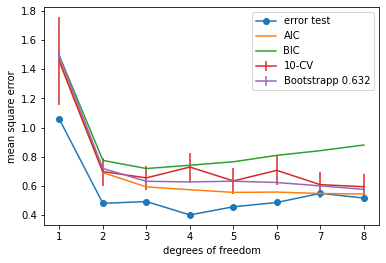

In [11]:
plt.plot(dofs,err_test,'o-',label='error test')
plt.plot(dofs,AIC,'-',label='AIC')
plt.plot(dofs,BIC,'-',label='BIC')
plt.errorbar(dofs,cv_mean,yerr=cv_sig,label='{}-CV'.format(n))
plt.errorbar(dofs,err_list_632,yerr=bs_sig_632,label='Bootstrapp 0.632')
plt.xlabel('degrees of freedom')
plt.ylabel('mean square error')
plt.legend()
plt.show()